In [ ]:
!pip install tqdm langdetect emoji

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import emoji
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from langdetect import detect

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/call_of_duty_reviews_50000.csv')
df.head()

,userName,content,score
0,User101,Best 👌 mobile game ever,5
1,User102,It's a really good game I'm going to rate it 1...,5
2,User103,Call of duty mobile is a very interesting game...,5
3,User104,"I love the game in it's entirety, the only thi...",3
4,User105,Unplayable size.... its portable. Update 2024 ...,1


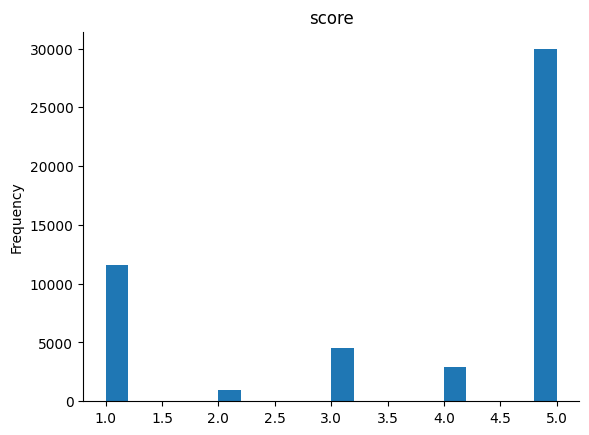

In [ ]:
df['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def convert_emojis_to_text(text):
    return emoji.demojize(text)

df['content'] = df['content'].apply(convert_emojis_to_text)

In [ ]:
tqdm.pandas()

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

if 'language' not in df.columns:  # Check if language column already exists
    print("Detecting language for the entire dataset...")
    df['language'] = df['content'].progress_apply(detect_language)  # Progress bar for full dataset
    df.to_csv('data_with_language.csv', index=False)  # Save data with language column
    print("Language detection and saving completed.")
else:
    print("Language column already exists. Loading from cached data...")
    df = pd.read_csv('data_with_language.csv')
    print("Data loaded successfully.")

Detecting language for the entire dataset...


100%|██████████| 50000/50000 [04:19<00:00, 192.32it/s]


Language detection and saving completed.


In [ ]:
print(df['language'].unique())
df['language'].value_counts()

['en' 'sw' 'nl' 'so' 'ca' 'da' 'fi' 'id' 'it' 'ar' 'tl' 'de' 'tr' 'sl'
 'ru' 'af' 'no' 'hr' 'vi' 'et']


,count
language,
en,38234
so,2407
ar,1000
id,968
de,910
tr,781
da,694
fi,600
it,546


In [ ]:
df.head()

,userName,content,score,language
0,User101,Best :OK_hand: mobile game ever,5,en
1,User102,It's a really good game I'm going to rate it 1...,5,en
2,User103,Call of duty mobile is a very interesting game...,5,en
3,User104,"I love the game in it's entirety, the only thi...",3,en
4,User105,Unplayable size.... its portable. Update 2024 ...,1,en


In [ ]:
list_language=['arabic', 'azerbaijani', 'danish', 'dutch', 'english',
                'finnish', 'french', 'german', 'greek', 'hungarian',
                'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian',
                'portuguese', 'romanian', 'russian', 'slovene', 'spanish',
                'swedish', 'tajik', 'turkish']

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words(list_language))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocess_text with progress bar
tqdm.pandas()
df['content'] = df['content'].progress_apply(preprocess_text)

100%|██████████| 50000/50000 [02:58<00:00, 280.08it/s]


In [ ]:
def assign_sentiment_label(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the sentiment labeling
df['sentiment'] = df['score'].apply(assign_sentiment_label)
df.head()

,userName,content,score,language,sentiment
0,User101,best mobile game ever,5,no,positive
1,User102,really good game going rate ad thank god v coo...,5,en,positive
2,User103,call duty mobile interesting game gaming mostl...,5,en,positive
3,User104,love game entirety thing dont like censorship ...,3,en,neutral
4,User105,unplayable size portable update huge still mak...,1,en,negative


In [ ]:
df.shape

(50000, 5)

In [ ]:
df.isnull().sum()

,0
userName,0
content,0
score,0
language,0
sentiment,0


In [ ]:
print(df.describe())

              score
count  50000.000000
mean       3.771560
std        1.675706
min        1.000000
25%        2.000000
50%        5.000000
75%        5.000000
max        5.000000


In [ ]:
df.head()

,userName,content,score,language,sentiment
0,User101,best mobile game ever,5,no,positive
1,User102,really good game going rate ad thank god v coo...,5,en,positive
2,User103,call duty mobile interesting game gaming mostl...,5,en,positive
3,User104,love game entirety thing dont like censorship ...,3,en,neutral
4,User105,unplayable size portable update huge still mak...,1,en,negative


In [ ]:
rating_distribution = df['score'].value_counts().sort_index()

distribution_table = pd.DataFrame({
    'Rating': rating_distribution.index,
    'Number of Reviews': rating_distribution.values
})

print("Distribution of Ratings:")
print(distribution_table.to_string(index=False))

Distribution of Ratings:
 Rating  Number of Reviews
      1              11619
      2               1000
      3               4500
      4               2946
      5              29935


In [ ]:
df.head()

In [ ]:
# (X) and labels (y)
X = df['content']
y = df['sentiment']

# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train

In [ ]:
 X_test

In [ ]:
y_train

In [ ]:
 y_test

In [ ]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf, X_test_tfidf

In [ ]:
# Initialize Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")

In [ ]:
# Initialize Logistic Regression classifier
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")

In [ ]:
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Models and vectorizer saved successfully!")

Models and vectorizer saved successfully!
